## Лабораторна робота 6. **Unsupervised Learning**

Оцінювання даної роботи буде ураховувати якість Ваших висновків та візуалізацій. При наявності ЛИШЕ коду та візуалізацій без роз'яснень, робота оцінюватися НЕ БУДЕ.  

Більшість поставлених в цій лабораторній роботі задач в майбутньому буде ставитись Вами самойстійно!

Під час виконання Вам дозволено користуватися будь-якими зручними для вас бібліотеками для візуалізації. 

Оформлення коментарів повинно проводитися в текстових комірках ноутбука з використанням синтаксису [LaTeX](https://en.wikibooks.org/wiki/LaTeX/Basics) для оформлення тексту та формул. 

Роботи ідентифіковані як ІДЕНТИЧНІ одразу отримують 0 балів.

## Кластерування  

В цій лабораторній роботі Ви будете вирішувати задачу класифікації БЕЗ вчителя. 

In [87]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline 

import os
import warnings


warnings.filterwarnings('ignore')

**Завдання 0** 

Для початку необхідно завантажити вибірку `Mall_Customers` і перейменувати атрибути `Annual Income (k$)` в `Income`,`Spending Score (1-100)` в `SpendingScore`

In [88]:
customer_set = pd.read_csv('Mall_Customers.csv')

In [89]:
customer_set = customer_set.rename(columns={'Annual Income (k$)':'Income','Spending Score (1-100)':'SpendingScore'})


**Завдання 1** 

Підготовка даних до опрацювання

* подивитись які атрибути містить вибірка; 
* вивести розмірність датасету;
* вивести основну статистичну інформацію по числовим змінним;  
* перевірити на наявність `NaN`.   

In [90]:
customer_set.sample(5)

,CustomerID,Gender,Age,Income,SpendingScore
65,66,Male,18,48,59
151,152,Male,39,78,88
144,145,Male,25,77,12
73,74,Female,60,50,56
61,62,Male,19,46,55


In [91]:
customer_set.shape

(200, 5)

In [92]:
customer_set.dtypes

CustomerID        int64
Gender           object
Age               int64
Income            int64
SpendingScore     int64
dtype: object

In [93]:
customer_set.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Income,200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
SpendingScore,200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [94]:
customer_set.isnull().sum()

CustomerID       0
Gender           0
Age              0
Income           0
SpendingScore    0
dtype: int64

## EDA Mall Customers

**Завдання 2** 

Як Ви могли помітити по статистичній аналітиці вибірки вона містить змінну `CustomerID`. Ця змінна не впливає на аналіз даних тому її можна видалити.

In [95]:
customer_set = customer_set.drop(['CustomerID'],axis=1)

**Завдання 3** 

Побудувати діаграми розподілу по змінним `Age` , `Income` та `SpendingScore`

<Axes: xlabel='SpendingScore', ylabel='Count'>

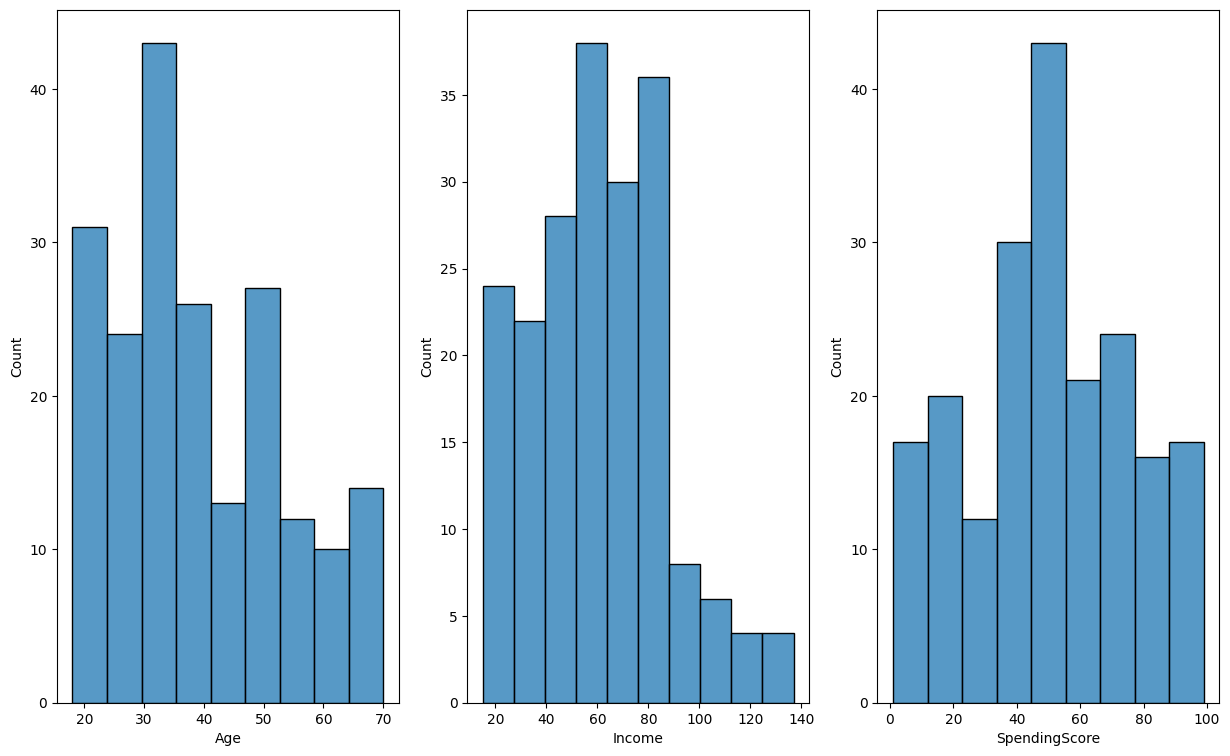

In [96]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 9))
sns.histplot(customer_set,x='Age',ax=axes[0])
sns.histplot(customer_set,x='Income',ax=axes[1])
sns.histplot(customer_set,x='SpendingScore',ax=axes[2])


**Завдання 4** 

Давайте подивимось на ці змінні `Age` , `Income` та `SpendingScore` відносно змінної `Gender`. 
* Побудуємо `pairplot` по всім змінним відностно змінної `Gender`:  
 
* Побудуємо `pairplot` використовуючи `sns.PairGrid` із заданими `(scatterplot)`, `(kdeplot)` та `(kdeplot, lw=1)` по відповідно правому верхньому куту, діагоналі і лівому нижньому кутут відносно змінної `Gender`:  
 

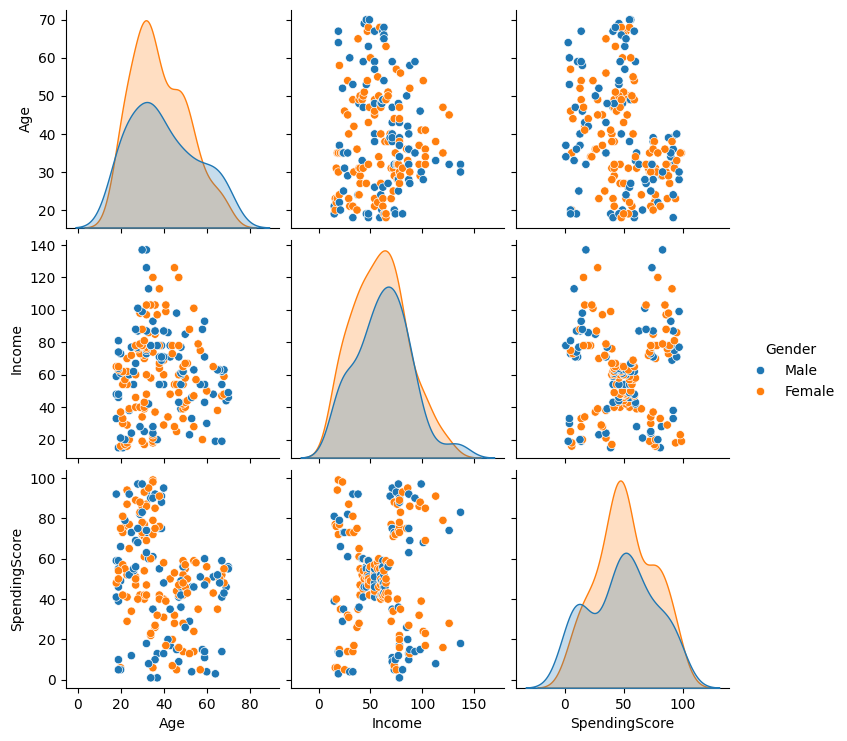

In [97]:
sns.pairplot(data=customer_set, hue='Gender', vars=['Age', 'Income', 'SpendingScore'])


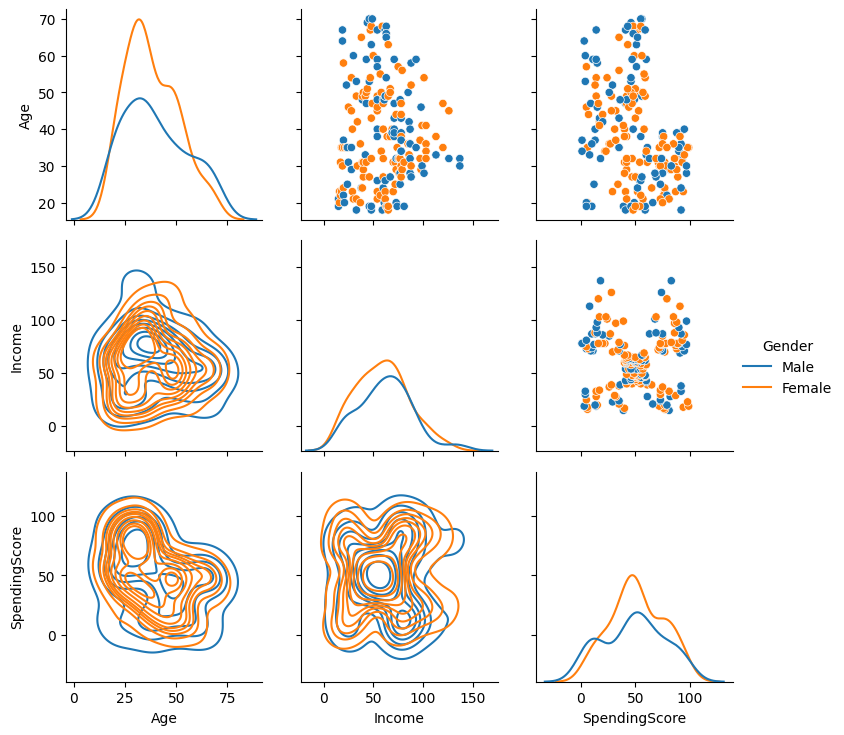

In [98]:
grid = sns.PairGrid(data=customer_set, hue='Gender', vars=['Age', 'Income', 'SpendingScore'])
grid.map_diag(sns.kdeplot)
grid.map_upper(sns.scatterplot)
grid.map_lower(sns.kdeplot, lw=1)
grid.add_legend()

**Висновки з 1-4 завдання (детальні)**

1. Завантажила свій датасет та провела звичайні статистичні обчислення і вияснила, що наш датасет має розмірність (200, 5). У датасеті також присутні такі типи даних, як числові та текстові. Пропущених даних в датасеті не має.
2. Поміили що в датасеті є колонка `CustomerID` ,яка ні на що не впливає тому ми її видалили
3. Побудували діаграми розподілу для змінних "Age", "Income" та "SpendingScore". За діаграмою розподілу віку можна сказати, що найбільше людей має вік від 20 до 30 років. За графіком доходів можна зробити висновок, що найбільше людей отримує зарплату від 60 до 80 тисяч доларів. Також з діаграми розподілу "SpendingScore" видно, що найбільший відсоток людей має рівень витрат на рівні 50%.
4. Поубудувалидва графіки розсіювання щоб подивитись на змінні `Age` , `Income` та `SpendingScore` відносно змінної `Gender`.На першому чітко видно прояви п'яти кластерів у датасеті  ,але при подальших дослідженнях ми змогли побачити також і те що у нас може бути і 3 кластери.

**Завдання 5** 

Проаналізувати змінну `Gender`:
* вивести співвідношення по статям;
* побудувати `countplot` по `Gender`;  
* побудувати `pie` по `Gender'.  

Gender
Female    56.0
Male      44.0
Name: proportion, dtype: float64


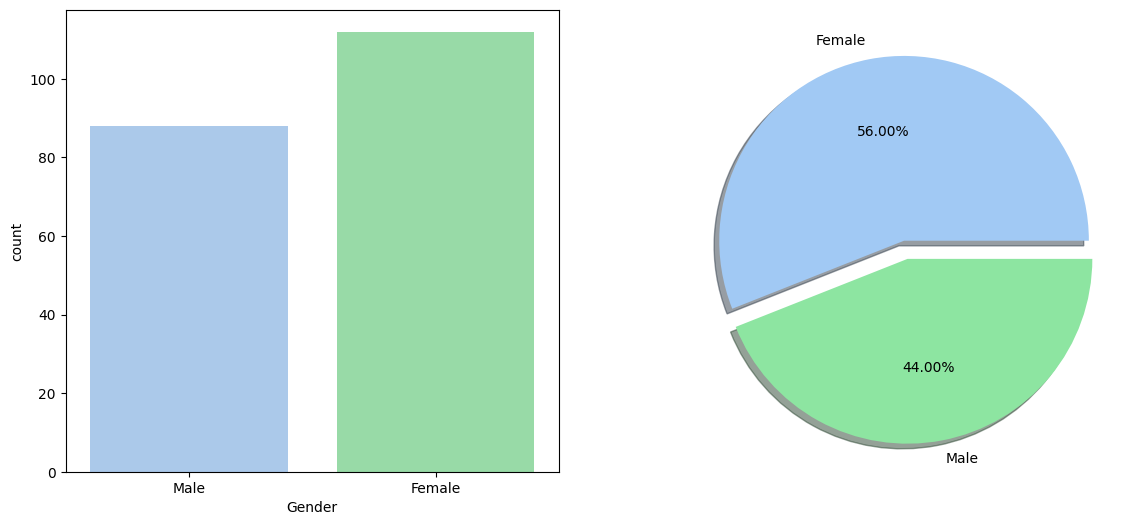

In [99]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
print(customer_set['Gender'].value_counts(normalize=True)*100)
sns.countplot(customer_set, x='Gender',ax=axes[0],palette='pastel6')
axes[1].pie(x=customer_set['Gender'].value_counts(),shadow=True,autopct='%0.2f%%',labels=['Female','Male'],explode=[0,0.1],colors=sns.color_palette('pastel6'))
plt.show()

**Завдання 6** 

Побудувати гістограми [histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html) змінних `Age` та `Income` відносно змінної `Gender` з різними параметрами:
*  подивитись на скільки змінюється візуалізація при різних значеннях параметра `multiple`, наприклад `dodge` та `layer`.

<Axes: xlabel='Income', ylabel='Count'>

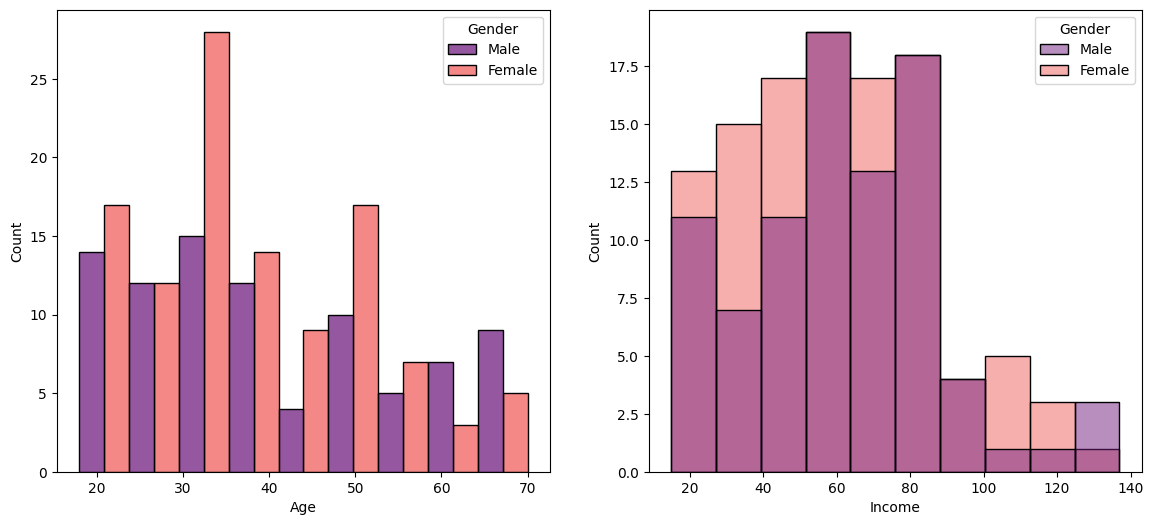

In [100]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

sns.histplot(data=customer_set, x="Age", hue="Gender", palette='magma', ax=axes[0], multiple='dodge')
sns.histplot(data=customer_set, x="Income", hue="Gender", palette='magma', ax=axes[1],multiple='layer')

**Завдання 7** 

Побудувати гістограми [histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html) змінної `SpendingScore` відносно змінної `Gender` з різними параметрами:  
* подивитись на скільки змінюється візуалізація при різних значеннях параметра `multiple`, наприклад `dodge` та `layer`. 



<Axes: xlabel='SpendingScore', ylabel='Count'>

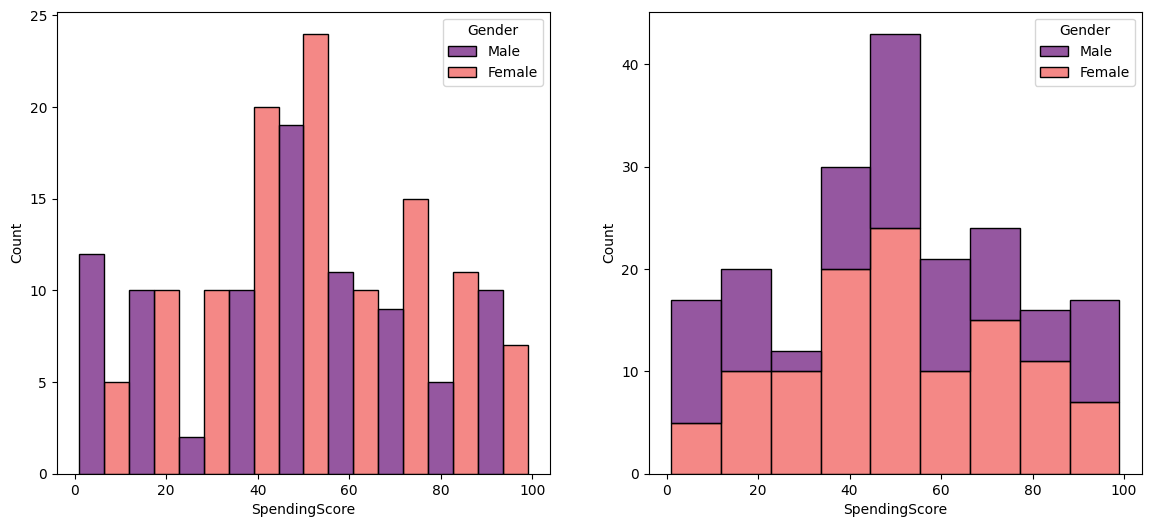

In [101]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

sns.histplot(data=customer_set, x="SpendingScore", hue="Gender", palette='magma', ax=axes[0],multiple='dodge')
sns.histplot(data=customer_set, x="SpendingScore", hue="Gender", palette='magma', ax=axes[1],multiple='stack')

**Завдання 8** 

Побудувати `boxplot` по змінній `SpendingScore` і подивитись як відрізняються витрати відностно змінної `Gender`. 

<Axes: ylabel='SpendingScore'>

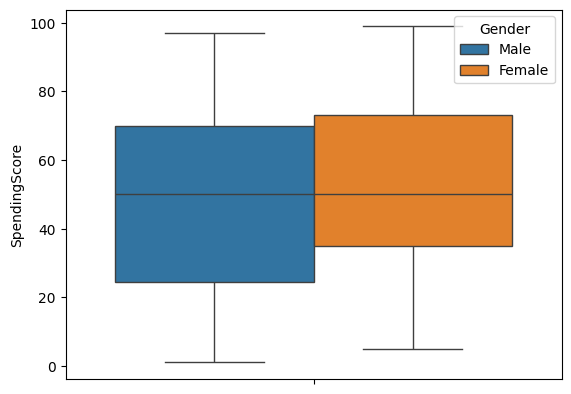

In [102]:
sns.boxplot(customer_set,y='SpendingScore',hue='Gender')

**Висновки з завдання 5 - 8(детальні)**

5.  Яке співвідношення груп чоловіків та жінок?
Співвідношення наших груп показало що жінок - більше за чоловіків 
6.  Подивитись які можна виділити групи і як розподілені витрати відностно статі людини? 
За графікми можна виділити такі групи дюдей: `низькі витрати `, `середні витрати ` та `високі витрати `
7. Чи є різниця між витратами у чоловіків та жінок?
При порівнянні двох грфіків про трати чоловіків та жінок видно що жінки тратять більше за чоловіків
8. На графіку показано, що у чоловіків показник витрат в діапазоні від 25 до 70, а у жінок від 35 до 75.

## K-means Method ##

**Завдання 9** 

Як Ви могли помітити, вибірка, з якою ми працюємо, не містить ключової зміної з вірними мітками. Тому перед початком кластерування необхідно визначити (підібрати) оптимальну кількість кластерів на яке буде проведено розбиття. Для цього необхідно:
1. видалити змінну `Gender`, тому що вона нам не потрібна для подальших аналітичних даних також це сексизм;  
2. задати мінімальну та максимальну кількість кластерів самостійно;  
3. На прикладі алгоритму [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), для ознайомлення з тим як працювати в умовах коли кількість кластерів невідома заздалегіть і немає вірних міток з позначками до якого кластеру відноситься спостереження пропонується використати метод [Elbow](https://coderoad.ru/19197715/Scikit-Learn-K-Means-Elbow-criterion) (додаткові джерела: [article_1](https://medium.com/analytics-vidhya/elbow-method-of-k-means-clustering-algorithm-a0c916adc540#:~:text=K%2Dmeans%20clustering%20is%20an,cluster%20with%20the%20nearest%20centroid.), [article_2](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/))

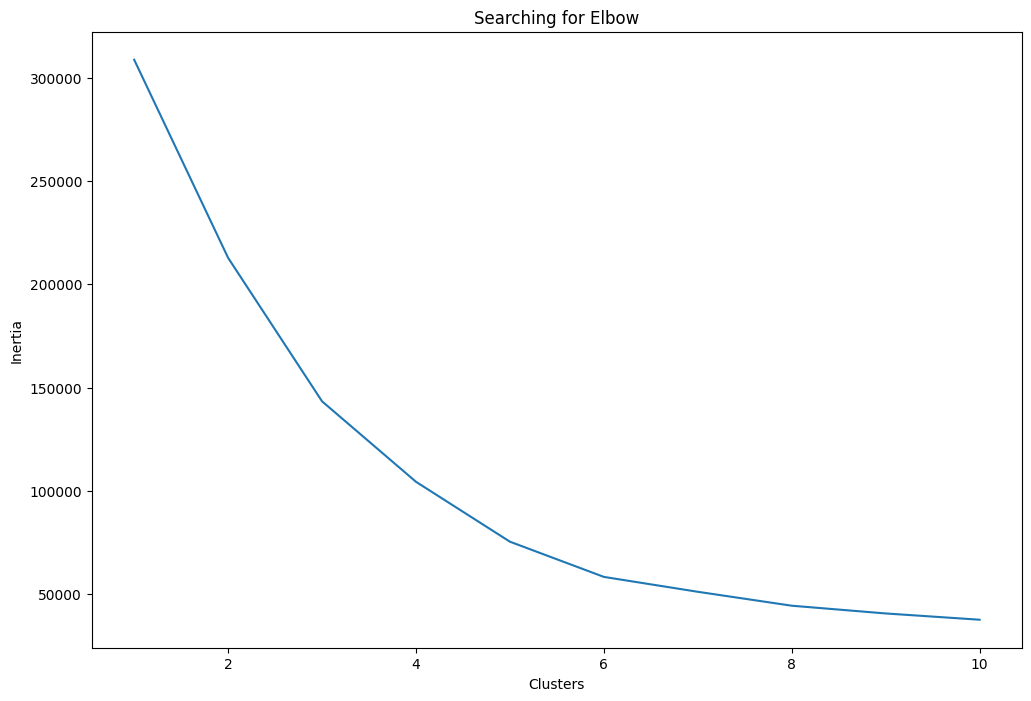

In [103]:
X = customer_set.drop(['Gender'], axis=1)
clusters = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',random_state=5)
    kmeans.fit(X)
    clusters.append(kmeans.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')


plt.show()

**Висновки з завдання 9 (детальні)** 

1.  Необхідно навести яка кількість кластерів на Вашу думку є оптимальною (краще розглянути для порівняння делька гіпотез про кількість кластерів)
При перегляді даних на очатковому етапі ми чітко бачили що кластерів є або 3 або 5 .Однак, після проведення аналізу методом "elbow", ми могли б припустити, що насправді в даних може бути ще шість кластерів.

**Завдання 10** 

Зробити двовимірну візуалізацію кластеризації методу К-середніх на вибраних Вами двох різних кількостях кластерів використовуючи змінні `Income` та `SpendingScore`. 

<Axes: xlabel='Income', ylabel='SpendingScore'>

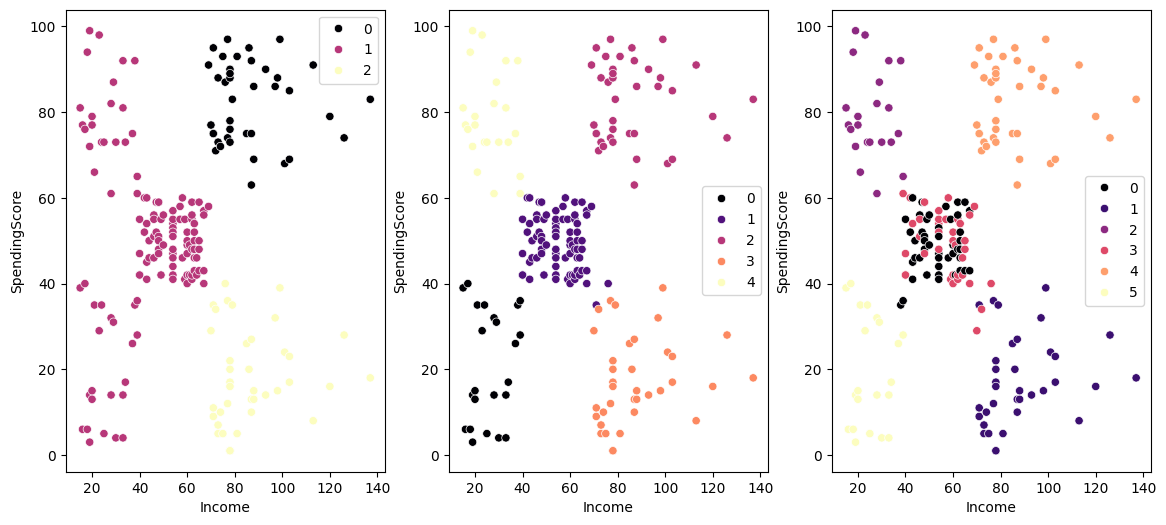

In [104]:
kmeans_3 = KMeans(n_clusters=3,random_state=42)
kmeans_5 = KMeans(n_clusters=5,random_state=42)
kmeans_6 = KMeans(n_clusters=6,random_state=42)

kmeans_3.fit(X)
kmeans_5.fit(X)
kmeans_6.fit(X)

fig, axes = plt.subplots(ncols=3, figsize=(14, 6))

sns.scatterplot(customer_set,x='Income',y='SpendingScore',hue=kmeans_3.labels_, palette='magma', ax=axes[0])
sns.scatterplot(customer_set,x='Income',y='SpendingScore',hue=kmeans_5.labels_, palette='magma',ax=axes[1])
sns.scatterplot(customer_set,x='Income',y='SpendingScore',hue=kmeans_6.labels_, palette='magma',ax=axes[2])



**Завдання 11** 

Зробити візуалізацію кластеризації методу К-середніх на вибраних Вами двох різних кількостях кластерів використовуючи [scatter_3d](https://plotly.com/python/3d-scatter-plots/).

In [105]:
fig_5 = px.scatter_3d(customer_set, x='Income', y='SpendingScore', z='Age',
                    color=kmeans_5.labels_, symbol=kmeans_5.labels_, opacity=0.7)
fig_6 = px.scatter_3d(customer_set, x='Income', y='SpendingScore', z='Age',
                    color=kmeans_6.labels_, symbol=kmeans_6.labels_, opacity=0.7)
fig_5.show()
fig_6.show()

**Висновки з завдання 10 - 11 (детальні)** 

1. Визначитась з отриманих візуалізацій яка кількість кластерів є оптимальною на Вашу думку і провести аналіз кластерів, що Ви отримали.
10. Ми зробили двовимірну візуалізацію методу К-середніх з трьома, п'ятьма та шістьма кластерами. На візуалізації, де ми вибрали три кластери, чітко видно, що розташування точок показує 5 кластерів, тому це припущення ми відкидаємо. Інша візуалізація тестувалась на п'яти кластерах і, на мою думку, ідеально підходить. Остання візуалізація була протестована на 6 кластерах та також показала непогані результати, і можна зробити припущення, що при тривимірній візуалізації ми зможемо побачити більше.
11. Для даних візуалізацій я вибрала 5 та 6 кластерів та проаналізувала їх. Візуалізація з п'ятьма кластерами показала хороший результат, проте скупчення в центрі дало думку про те, що може бути ще один кластер. При запуску візуалізації з шістьма кластерами я побачила, що вони добре розподілились та краще відображаються.


## Agglomerative clustering ##

Розглянемо ще один підхід до кластеризації - [агломеративну ієрархічну кластеризацію](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

**Завдання 12** 

Кластеризуйте датасет за допомогою [агломеративної ієрархічнуої кластеризації](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

Мінімально необхідні параметри, що треба налаштувати:  
* `n_clusters`: параметр, який відповідає за кільксіть кластерів на яку буде проведено розбиття вибірки;  
* `linkage`: параметр зв’язку. Цей параметр визначає, яку відстань використовувати між наборами спостережень.
* перевірте як працює цей метод з різними параметрами `linkage`  
* після кожної зміни параметрів - візуалізувати розбиття на кластери

Розрахувати матрицю відстаней для нашого набору даних:
* за допомогою методу [hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) і матриці відстаней кластеризувати дані з різними значеннями параметра `method`
* за допомогою методу [hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) візуалізувати отримані результати кластеризації у вигляді дендрограм


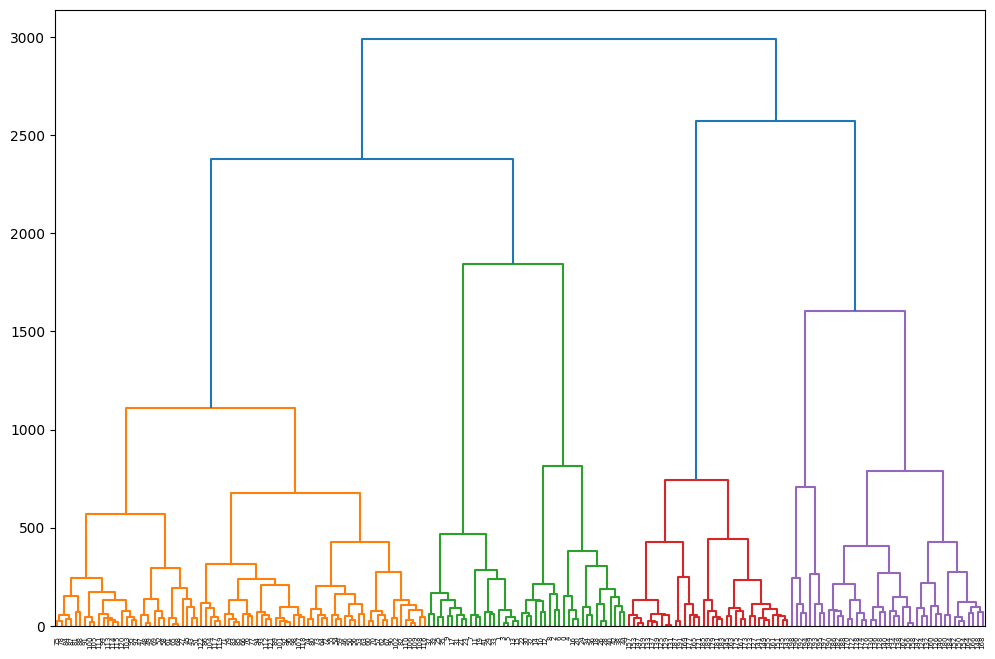

In [112]:
matrix_data = customer_set.drop(['Gender'],axis=1)
dist_matrix = distance_matrix(matrix_data.values, matrix_data.values)

agglomerative_clustering = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
agglomerative_labels = agglomerative_clustering.fit_predict(matrix_data)

plt.figure(figsize=(12, 8))
dendogram = hierarchy.dendrogram(hierarchy.linkage(dist_matrix, method='ward'))
plt.show()

**Висновки з завдання 12 (детальні)**

1. Використовуючи метод агломеративної кластеризації з шістьма кластерами, ми отримали досить позитивні результати. Візуалізація дендрограми показує  поділ на пять груп, що не відповідає моїм очікуванням та ідеї про наявність шести категорій клієнтів.

**Завдання 13** 

А тепер зробимо порівняльний аналіз отриманих результатів кластеризації розглянутими методами:  
* В фінальних візуалізаціях треба використовувати **однакову** (на вашу думку оптимальну) кількість кластерів!!!  

Text(0.5, 1.0, 'Agglomerative clustering')

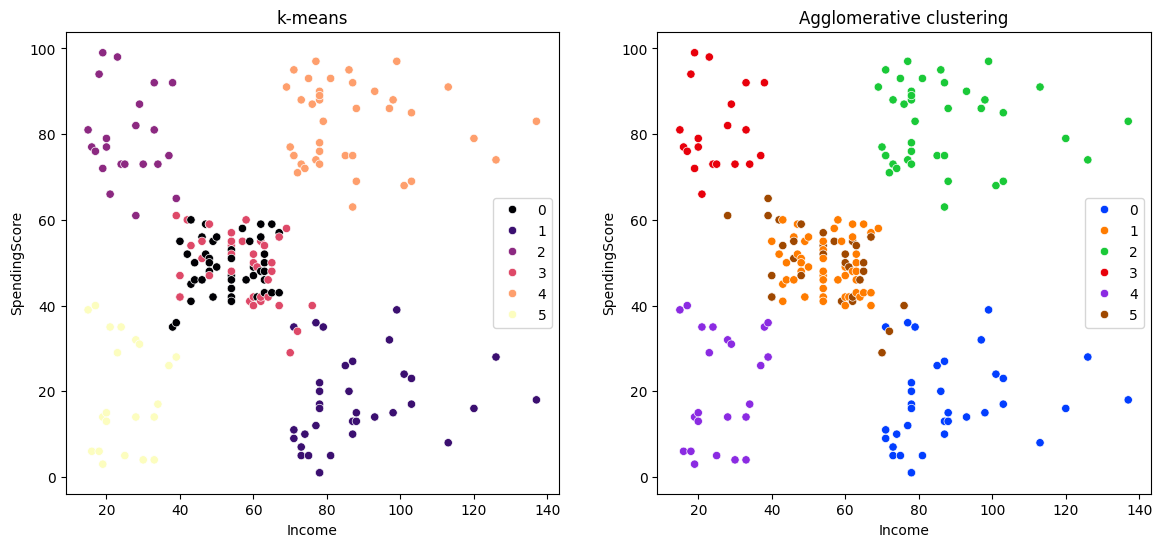

In [113]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

sns.scatterplot(customer_set,x='Income',y='SpendingScore',hue=kmeans_6.labels_, palette='magma',ax=axes[0])
axes[0].set_title('k-means')
sns.scatterplot(customer_set,x='Income',y='SpendingScore',hue=agglomerative_labels, palette='bright',ax=axes[1])
axes[1].set_title('Agglomerative clustering')


**Висновки з завдання 13 (детальні)**

1. На фінальних візуалізаціях ми використали 6 кластерів і застосували до них методи k-means і агломеративного кластерування. Обидва методи показали хороші результати, але k-means можливо трохи краще через більшу кількість точок у центрі з різних кластерів.